In [11]:
!pip install eli5
!pip install --upgrade tables
!git config --global user.email "kmwolowiec@gmail.com"
!git config --global user.name "Krzysiek"

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [0]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [12]:
cd "drive/My Drive/Colab Notebooks/data_workshop"

/content/drive/My Drive/Colab Notebooks/data_workshop


Import data

In [0]:
df = pd.read_hdf('data/car.h5')

In [25]:
df.shape

(106494, 155)

In [26]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

# Dummy Model

In [27]:
df.select_dtypes(np.number).columns

Index(['price_value', 'car_id'], dtype='object')

In [28]:
X = df['car_id']
y = df['price_value']

model = DummyRegressor()
model.fit(X, y)
y_pred = model.predict(X)

mae(y, y_pred)

39465.934630440985

In [29]:
[x for x in df.columns if 'price' in x]

['price_currency', 'price_details', 'price_value']

In [30]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [31]:
df = df[ df.price_currency == 'PLN']
df.shape

(106290, 155)

# Features

In [32]:
df.sample(5)

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,...,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
29767,"[Osobowe, Volkswagen, Golf Plus]","08:43, 2 marca 2018",PLN,Cena Brutto,17950.0,"ul. Szczecińska 2 - 76-200 Słupsk, Pomorskie ...",AUTO CENTRUM II,Dealer,False,False,True,True,False,False,True,True,True,True,True,True,False,False,True,True,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,...,None,None,Firmy,136 KM,None,None,None,None,None,Diesel,Tak,None,None,None,None,None,None,Golf Plus,1 968 cm3,None,None,None,None,None,None,None,None,None,Szary,None,None,Używane,None,None,None,None,None,None,None,29767
43724,"[Osobowe, Citroën, C3, Citroën C3 I (2002-2009)]","22:18, 27 lutego 2018",PLN,"Cena Brutto, Do negocjacji",8500.0,"Ostrzeszów, ostrzeszowski, Wielkopolskie",None,Osoba prywatna,False,True,False,False,False,False,True,False,True,True,True,True,False,False,True,False,True,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,...,None,None,Osoby prywatnej,73 KM,None,Niemcy,None,None,Tak,Benzyna,None,None,None,None,None,None,None,C3,1 360 cm3,None,None,None,None,None,None,None,None,None,Srebrny,None,None,Używane,I (2002-2009),None,None,None,Tak,None,None,43724
22635,"[Osobowe, Citroën, Berlingo, Citroën Berlingo ...","08:38, 3 marca 2018",PLN,Cena Brutto,15900.0,"ciechanów - 06-300 Przasnysz, przasnyski, Mazo...",Moto Detal,Dealer,False,False,False,False,False,False,True,True,True,True,True,True,False,False,True,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,None,Tak,Firmy,None,None,None,None,None,None,Diesel,None,None,None,None,None,None,None,Berlingo,1 600 cm3,None,None,None,None,None,None,None,None,None,Złoty,None,None,Używane,II (2008-),None,None,None,Tak,None,None,22635
99637,"[Osobowe, Škoda, Fabia, Škoda Fabia I (1999-20...","15:30, 27 lutego 2018",PLN,"Cena Brutto, Do negocjacji",4900.0,"Luboń, poznański, Wielkopolskie",None,Osoba prywatna,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,...,None,Tak,Osoby prywatnej,65 KM,None,None,None,None,None,Diesel,None,None,None,None,None,None,None,Fabia,1 900 cm3,None,None,Non

In [0]:
suffix_cat = '__cat'
for feat in df.columns:
    if isinstance(df[feat][0], list):continue
    
    factorized_values = df[feat].factorize()[0]
    if suffix_cat in feat:
        df[feat] = factorized_values
    
    else:
        df[feat+suffix_cat] = factorized_values

In [36]:
cat_feats = [x for x in df.columns if suffix_cat in x]
cat_feats = [x for x in cat_feats if 'price' not in x]
cat_feats

['created_at__cat',
 'seller_address__cat',
 'seller_name__cat',
 'seller_type__cat',
 'feature_czujniki-parkowania-przednie__cat',
 'feature_poduszka-powietrzna-chroniąca-kolana__cat',
 'feature_kurtyny-powietrzne__cat',
 'feature_klimatyzacja-dwustrefowa__cat',
 'feature_światła-led__cat',
 'feature_czujnik-zmierzchu__cat',
 'feature_elektrycznie-ustawiane-lusterka__cat',
 'feature_asr-(kontrola-trakcji)__cat',
 'feature_poduszka-powietrzna-kierowcy__cat',
 'feature_cd__cat',
 'feature_elektryczne-szyby-przednie__cat',
 'feature_poduszka-powietrzna-pasażera__cat',
 'feature_system-start-stop__cat',
 'feature_światła-do-jazdy-dziennej__cat',
 'feature_komputer-pokładowy__cat',
 'feature_elektryczne-szyby-tylne__cat',
 'feature_klimatyzacja-manualna__cat',
 'feature_tapicerka-welurowa__cat',
 'feature_czujnik-deszczu__cat',
 'feature_światła-przeciwmgielne__cat',
 'feature_ogrzewanie-postojowe__cat',
 'feature_radio-niefabryczne__cat',
 'feature_regulowane-zawieszenie__cat',
 'feature_

In [37]:
len(cat_feats)

151

In [41]:
X = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)

-19566.588937368324

In [43]:
m = DecisionTreeRegressor(max_depth=5)
m.fit(X, y)

imp = PermutationImportance(m, random_state=0).fit(X, y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.2533 ± 0.0040,param_napęd__cat
0.2008 ± 0.0047,param_faktura-vat__cat
0.1943 ± 0.0088,param_stan__cat
0.1423 ± 0.0086,param_rok-produkcji__cat
0.0629 ± 0.0047,param_moc__cat
0.0424 ± 0.0014,feature_kamera-cofania__cat
0.0412 ± 0.0008,param_skrzynia-biegów__cat
0.0286 ± 0.0037,param_marka-pojazdu__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0163 ± 0.0005,feature_bluetooth__cat


In [48]:
df[['param_napęd', 'price_value']].groupby('param_napęd').agg(['mean', 'median', 'std', 'count'])

price_value                               
                                        mean   median            std  count
param_napęd                                                                
4x4 (dołączany automatycznie)  113187.789516  77900.0  105202.455754   6859
4x4 (dołączany ręcznie)         44905.320252  27900.0   50490.080308   1628
4x4 (stały)                    142511.603888  93000.0  134984.949108   6945
Na przednie koła                32813.364308  22000.0   30721.762847  65926
Na tylne koła                   58415.661494  29900.0   76253.787335   8589

In [0]:
df['param_rok-produkcji'] = df['param_rok-produkcji'].astype(float)

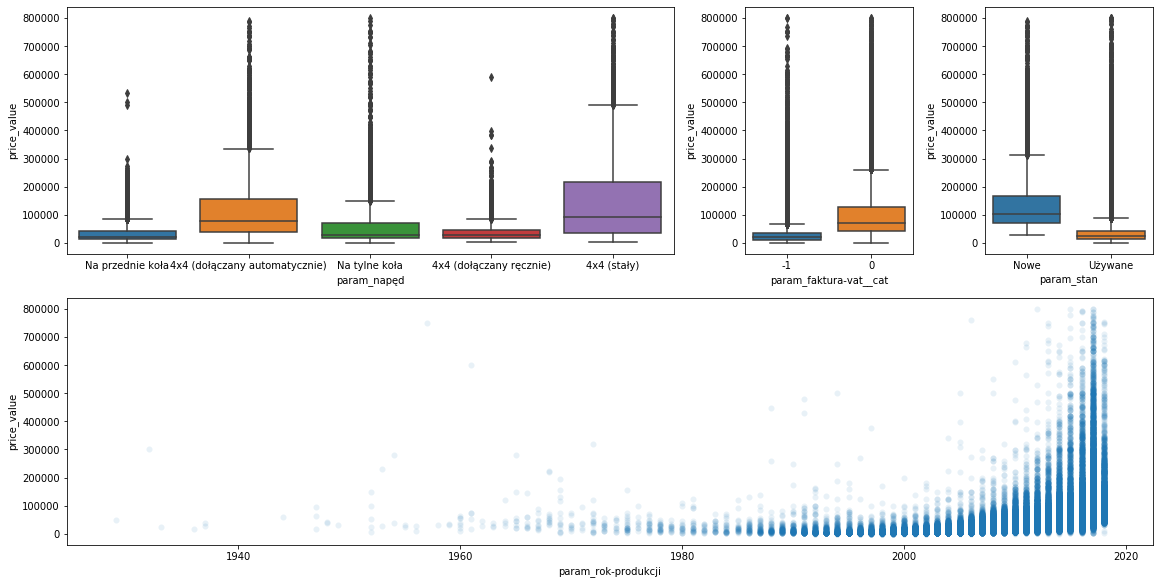

In [198]:
fig = plt.figure(constrained_layout=True, figsize=(16,8))

gs = GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[1, :])

sns.boxplot(data=df, x='param_napęd', y='price_value', ax=ax1)
sns.boxplot(data=df, x='param_faktura-vat__cat', y='price_value', ax=ax2)
sns.boxplot(data=df, x='param_stan', y='price_value', ax=ax3)
sns.scatterplot(x="param_rok-produkcji", y="price_value", data=df, alpha=0.1, linewidth=0, ax=ax4);

In [0]:
!git commit -m matrix_two/day3.ipynb ""